In [1]:
!pip install kaggle

In [2]:
from google.colab import files

# Upload the Kaggle API key (kaggle.json) that you downloaded
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d muhammadkhalid/sign-language-for-numbers


100% 48.0M/48.1M [00:02<00:00, 29.4MB/s]
100% 48.1M/48.1M [00:02<00:00, 19.8MB/s]


In [5]:
!unzip -q sign-language-for-numbers.zip


In [9]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


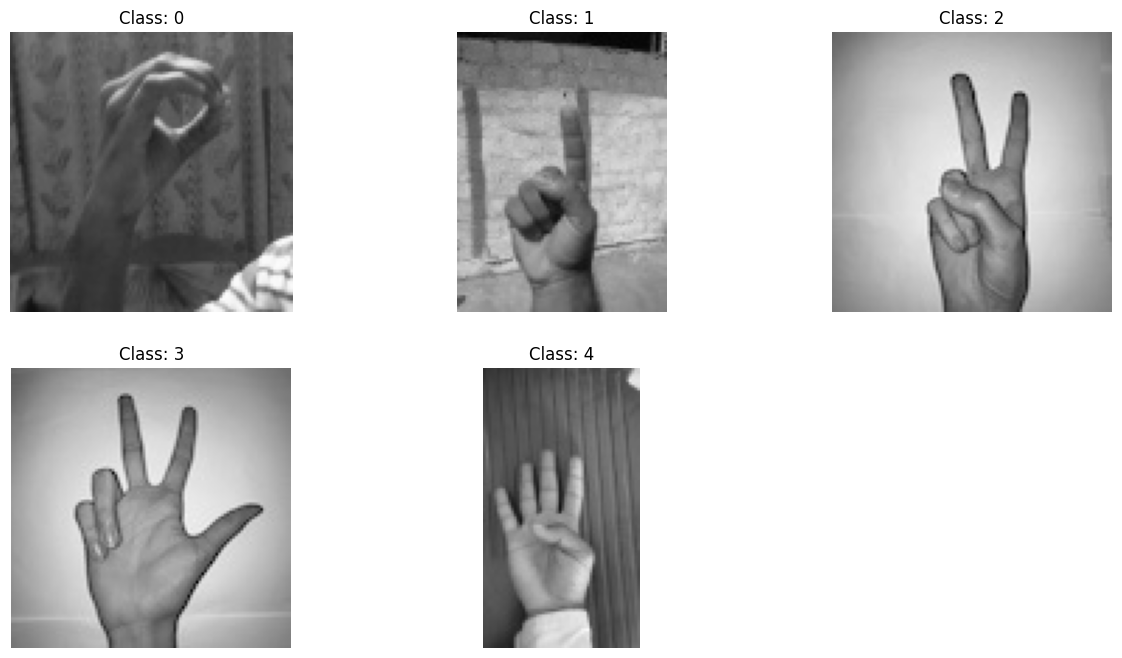

In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Set the path to the extracted dataset folder
dataset_path = "/content/sign-language-for-numbers"

# Get class labels (folder names)
class_labels = sorted(os.listdir(dataset_path))

# Display 5 images from 5 different classes
plt.figure(figsize=(15, 8))
for i, class_label in enumerate(class_labels[:5]):
    class_folder = os.path.join(dataset_path, class_label)
    image_files = os.listdir(class_folder)
    random_image = random.choice(image_files)

    image_path = os.path.join(class_folder, random_image)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Class: {class_label}")
    plt.axis("off")

plt.show()


In [12]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [13]:
# Function to load and preprocess images and labels from folders
def load_and_preprocess_data(folder_path):
    images = []
    labels = []
    class_labels = sorted(os.listdir(folder_path))

    # Exclude "unknown" class
    class_labels = [label for label in class_labels if label != "unknown"]

    for label, class_name in enumerate(class_labels):
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read image in color
            img = cv2.resize(img, (100, 100))  # Resize to VGG16 input size
            img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(class_name)

    return np.array(images), np.array(labels)

In [14]:
folder_path = "/content/sign-language-for-numbers"
images, labels = load_and_preprocess_data(folder_path)

In [15]:
# Encode class labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
encoded_labels = to_categorical(encoded_labels)

In [16]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, encoded_labels, test_size=0.2, random_state=42)

In [17]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(100, 100, 3))


58889256/58889256 [==============================] - 3s 0us/step


In [18]:
# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


In [19]:
# Create a new model by adding custom layers on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

In [20]:
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


In [21]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))



Epoch 1/10
750/750 [==============================] - 29s 30ms/step - loss: 1.0223 - accuracy: 0.6595 - val_loss: 0.4577 - val_accuracy: 0.8640
Epoch 2/10
750/750 [==============================] - 19s 26ms/step - loss: 0.4959 - accuracy: 0.8347 - val_loss: 0.3171 - val_accuracy: 0.9027
Epoch 3/10
750/750 [==============================] - 20s 26ms/step - loss: 0.3699 - accuracy: 0.8770 - val_loss: 0.2464 - val_accuracy: 0.9127
Epoch 4/10
750/750 [==============================] - 20s 27ms/step - loss: 0.3202 - accuracy: 0.8921 - val_loss: 0.2033 - val_accuracy: 0.9337
Epoch 5/10
750/750 [==============================] - 20s 27ms/step - loss: 0.2675 - accuracy: 0.9091 - val_loss: 0.2227 - val_accuracy: 0.9273
Epoch 6/10
750/750 [==============================] - 19s 25ms/step - loss: 0.2341 - accuracy: 0.9211 - val_loss: 0.1748 - val_accuracy: 0.9437
Epoch 7/10
750/750 [==============================] - 20s 27ms/step - loss: 0.2258 - accuracy: 0.9193 - val_loss: 0.1571 - val_accuracy:

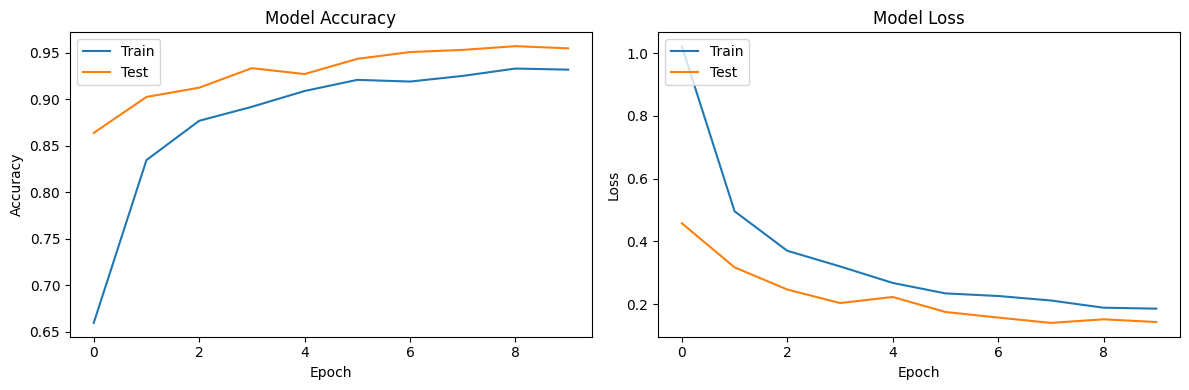

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()
# Save the fine-tuned model
model.save("/content/sign.h5")